In [1]:
#!pip install -U scikit-learn
#!pip install autograd
#!pip install tensorflow

## Preliminary: the softmax function

The softmax function plays a crucial role in neural networks, particularly in the output layer of classification models. Its primary purpose is to convert a vector of real numbers into a probability distribution over multiple classes. 

$$\text{Softmax}(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K
 $$

First, each element of the input vector is exponentiated (raised to the power of $e$), which makes all values positive.  The exponentiation step amplifies the differences between the input values. Larger values get significantly larger, and smaller values remain relatively small. This emphasizes the model's confidence in its predictions.

After exponentiation, the softmax function normalizes the values by dividing each exponentiated value by the sum of all exponentiated values in the input vector. This step ensures that the output vector sums up to 1, making it a valid probability distribution.

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the following 2-class dataset:

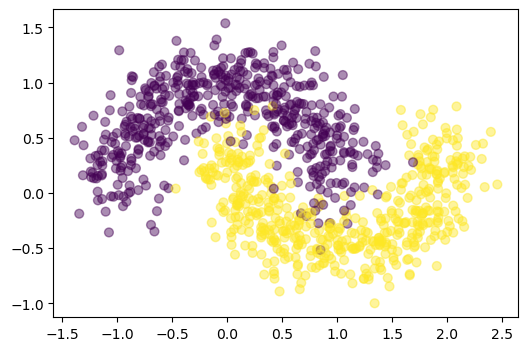

In [2]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

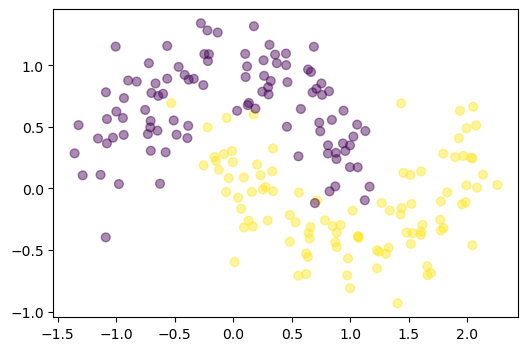

In [3]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [4]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [5]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2). 
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \text{Softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 


## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**. 

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

In [7]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

                       # num_passes=50000
def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

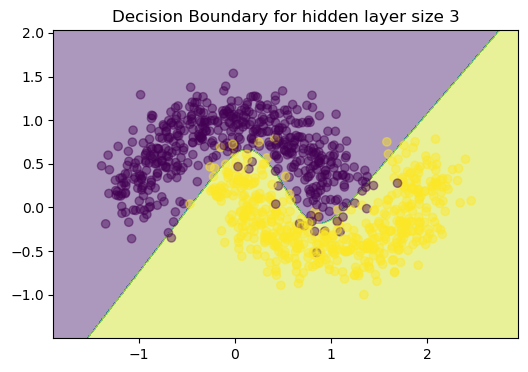

In [9]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [10]:
ourPredictions = predict(model, Xt)

accuracy = np.mean(ourPredictions == yt)

print(f"Classification Accuracy: {accuracy * 100:.2f}%")

Classification Accuracy: 95.50%


# Exercise 2

+ Add an additional layer to your neural network model. 
+ Change the activation function and use a ReLU. 


Loss after iteration 0: 0.680328
Loss after iteration 1000: 0.263123
Loss after iteration 2000: 0.248665
Loss after iteration 3000: 0.198658
Loss after iteration 4000: 0.127351
Loss after iteration 5000: 0.106162
Loss after iteration 6000: 0.099658
Loss after iteration 7000: 0.096651
Loss after iteration 8000: 0.094996
Loss after iteration 9000: 0.093741
Loss after iteration 10000: 0.092908
Loss after iteration 11000: 0.092343
Loss after iteration 12000: 0.091956
Loss after iteration 13000: 0.091676
Loss after iteration 14000: 0.091410
Loss after iteration 15000: 0.090917
Loss after iteration 16000: 0.090267
Loss after iteration 17000: 0.089921
Loss after iteration 18000: 0.089717
Loss after iteration 19000: 0.089584
Loss after iteration 20000: 0.089492
Loss after iteration 21000: 0.089424
Loss after iteration 22000: 0.089372
Loss after iteration 23000: 0.089330
Loss after iteration 24000: 0.089293
Loss after iteration 25000: 0.089260
Loss after iteration 26000: 0.089230
Loss after ite

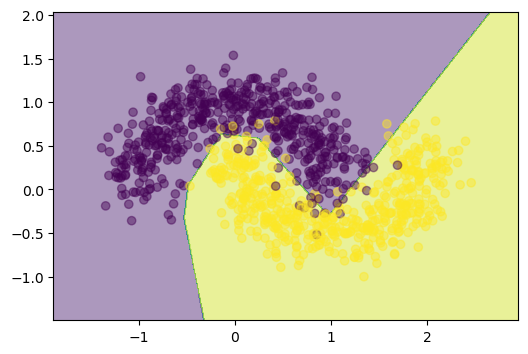

In [11]:
import autograd.numpy as np
from autograd import grad

def relu(z):
    return np.maximum(0, z)

def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    num_examples = X.shape[0]

    # Using ReLU activation for the first and second layer
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)  
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Calculate the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)

    return 1. / num_examples * data_loss

# Define prediction function using ReLU activation for both layers
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x, W1) + b1
    a1 = relu(z1)  
    z2 = np.dot(a1, W2) + b2
    a2 = relu(z2) 
    z3 = np.dot(a2, W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

nn_input_dim = 2  # input layer dimensionality
nn_output_dim = 2  # output layer dimensionality
num_examples = len(X)  # training set size
epsilon = 0.03  # Learning rate

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

    for i in range(0, num_passes):
        # Forward propagation
        predict(model, X)

        gradient_loss = grad(loss)

        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))

        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (i, loss(model)))

    return model

model = build_model(4, print_loss=True)
predictions = predict(model, Xt)
accuracy = np.mean(predictions == yt)

# Print the accuracy
print(f"Classification Accuracy on Testing Dataset: {accuracy * 100:.2f}%")
plot_decision_boundary(lambda x: predict(model, x))

# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. 
+ Train the model and report the classification accuracy using the testing dataset.


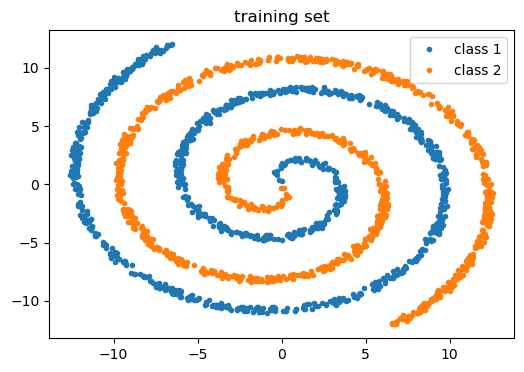

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [13]:
def plot_decision_boundary_spiral(X_test, y_test, model):
    plt.title('Decision Boundary')
    plt.plot(X_test[y_test == 0, 0], X_test[y_test == 0, 1], '.', label='class 1')
    plt.plot(X_test[y_test == 1, 0], X_test[y_test == 1, 1], '.', label='class 2')

    xx, yy = np.meshgrid(np.arange(-20, 20, 0.1), np.arange(-20, 20, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], colors=['blue', 'orange'], alpha=0.2)
    plt.legend()
    plt.show()

2023-10-19 14:54:57.800798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
27/27 [==============================] - 1s 3ms/step - loss: 0.3839 - accuracy: 0.4956
Epoch 2/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2574 - accuracy: 0.5431
Epoch 3/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.5800
Epoch 4/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2343 - accuracy: 0.6237
Epoch 5/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2343 - accuracy: 0.6025
Epoch 6/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2359 - accuracy: 0.5875
Epoch 7/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2366 - accuracy: 0.6106
Epoch 8/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2297 - accuracy: 0.6263
Epoch 9/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2354 - accuracy: 0.6119
Epoch 10/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2334 - accuracy: 0.6200
Epoch 11/

27/27 [==============================] - 0s 2ms/step - loss: 0.2065 - accuracy: 0.6625
Epoch 84/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.6712
Epoch 85/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.6800
Epoch 86/500
27/27 [==============================] - 0s 2ms/step - loss: 0.2012 - accuracy: 0.6944
Epoch 87/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.7125
Epoch 88/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.7244
Epoch 89/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1941 - accuracy: 0.6913
Epoch 90/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1875 - accuracy: 0.7113
Epoch 91/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1907 - accuracy: 0.6931
Epoch 92/500
27/27 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.7262
Epoch 93/500


27/27 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.9875
Epoch 246/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9925
Epoch 247/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.9919
Epoch 248/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0107 - accuracy: 0.9887
Epoch 249/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9906
Epoch 250/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.9931
Epoch 251/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0099 - accuracy: 0.9950
Epoch 252/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0201 - accuracy: 0.9825
Epoch 253/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.9862
Epoch 254/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.9581
Epoc

27/27 [==============================] - 0s 2ms/step - loss: 0.0074 - accuracy: 0.9931
Epoch 408/500
27/27 [==============================] - 0s 3ms/step - loss: 0.0073 - accuracy: 0.9956
Epoch 409/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.9944
Epoch 410/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 0.9962
Epoch 411/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.9887
Epoch 412/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 0.9894
Epoch 413/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.9881
Epoch 414/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.9906
Epoch 415/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.9925
Epoch 416/500
27/27 [==============================] - 0s 2ms/step - loss: 0.0086 - accuracy: 0.9931
Epoc

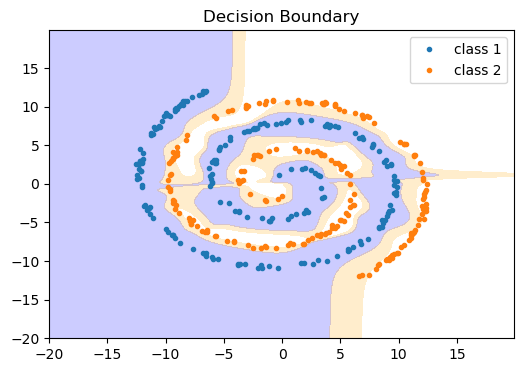

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop, Adam, AdamW
from keras.models import Sequential
from keras.layers import Dense

spirals_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),  # Input layer with 2 features
    tf.keras.layers.Dense(8, activation='tanh'),  # Hidden layer with 8 neurons and tanh activation
    tf.keras.layers.Dense(6, activation='tanh'),  # Hidden layer with 6 neurons and tanh activation
    tf.keras.layers.Dense(4, activation='tanh'),  # Hidden layer with 4 neurons and tanh activation
    tf.keras.layers.Dense(2, activation='tanh'),  # Hidden layer with 2 neurons and tanh activation
    tf.keras.layers.Dense(1, activation='relu')  # Output layer with 1 neuron and sigmoid activation for binary classification
])

learning_rate=0.01
#----------------------------
    #Using some diffrent optimisers, most of the time AdamW preformes best! 
#----------------------------
#spirals_model.compile(optimizer=Adam(learning_rate),loss='mse', metrics=['accuracy'])
    #Adam Res = Final Loss: 0.001749834162183106, Final Accuracy: 1.0
#----------------------------
spirals_model.compile(optimizer=AdamW(learning_rate),loss='mse', metrics=['accuracy'])
    #AdamW Res = Final Loss: 0.001369555713608861, Final Accuracy: 1.0
#----------------------------
#spirals_model.compile(optimizer=RMSprop(learning_rate), loss='mse', metrics=['accuracy'])
    #RMSprop = Final Loss: 0.002657943172380328, Final Accuracy: 0.9950000047683716
#----------------------------

# Split the data into training and test sets, where 20% of the data is reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training data
spirals_model.fit(X_train, y_train, epochs=500, batch_size=60)


# Evaluate the model on the test data
loss, accuracy = spirals_model.evaluate(X_test, y_test)
print(f"Final Loss: {loss}, Final Accuracy: {accuracy}")
#----------------------------

plot_decision_boundary_spiral(X_test, y_test, spirals_model)

